In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link='https://drive.google.com/open?id=1NOrtLjmCvURr5DpWjGSSNJRJTa__x8o_'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('stemmed.csv')

1NOrtLjmCvURr5DpWjGSSNJRJTa__x8o_


In [0]:
import pandas as pd
import numpy as np

In [0]:
df = pd.read_csv("stemmed.csv", engine="python", index_col=0)
df.head()

,text,sentiment
0,awww that bummer shoulda got david carr third day,0
1,upset cant updat facebook text might cri resul...,0
2,dive mani time ball manag save rest go bound,0
3,whole bodi feel itchi like fire,0
4,no not behav im mad cant see,0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


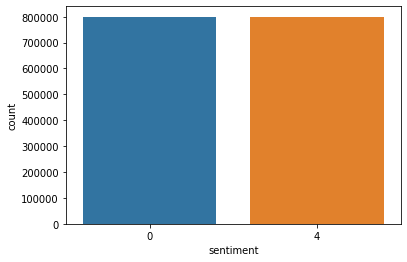

In [0]:
import seaborn as sns

sns.countplot(x='sentiment', data=df)

In [0]:
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1593391 entries, 0 to 1593390
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   text       1593391 non-null  object
 1   sentiment  1593391 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.3+ MB


In [0]:
df_words = df
df_words.head()
df_words["count"] = df_words.text.apply(lambda x: len(x.split(' ')))

In [0]:
df_words.head()

,text,sentiment,count
0,awww that bummer shoulda got david carr third day,0,9
1,upset cant updat facebook text might cri resul...,0,12
2,dive mani time ball manag save rest go bound,0,9
3,whole bodi feel itchi like fire,0,6
4,no not behav im mad cant see,0,7


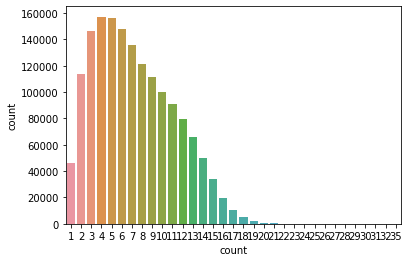

In [0]:
sns.countplot(x='count', data=df_words)

# Global Configuration

In [0]:
MAX_WORDS = 14
EMBEDDING_SIZE = 32
BATCH_SIZE = 5000
EPOCHS = 10
LSTM_CELLS = 128
LSTM_DROPOUT = 0.3
LSTM_RECURRENT_DROPOUT = 0
DROPOUT_AFTER_EMBEDDING = 0
VOCAB_SIZE = 50000


# Tokenization

In [0]:
x = df['text']
y = [1 if x == 4 else 0 for x in df['sentiment']]

In [0]:
from keras.preprocessing import sequence 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(x)
x = pad_sequences(tokenizer.texts_to_sequences(x), maxlen=MAX_WORDS, padding="post")

vocab_size = len(tokenizer.word_index) + 1
print('vocab size is : ', vocab_size)



Using TensorFlow backend.


vocab size is :  369217


In [0]:
total_words = 0
for rev in df['text']:
  total_words += len(rev.split())

print("words/review average : ", total_words/1600000)

words/review average :  7.2457475


# Neural Network


In [0]:
# Build the model
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU
from keras import optimizers
from keras import regularizers

model=Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_WORDS))
if DROPOUT_AFTER_EMBEDDING!=0:
  model.add(Dropout(DROPOUT_AFTER_EMBEDDING))
model.add(LSTM(LSTM_CELLS,dropout=LSTM_DROPOUT, recurrent_dropout=LSTM_RECURRENT_DROPOUT))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 14, 32)            11814944  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 11,897,505
Trainable params: 11,897,505
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.01, random_state = 0)

In [0]:
hist = model.fit(xTrain, yTrain, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, shuffle=True, validation_split=0.01)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1561682 samples, validate on 15775 samples
Epoch 1/10
1561682/1561682 [==============================] - 455s 292us/step - loss: 0.4919 - acc: 0.7579 - val_loss: 0.4471 - val_acc: 0.7887
Epoch 2/10
1561682/1561682 [==============================] - 461s 295us/step - loss: 0.4392 - acc: 0.7962 - val_loss: 0.4426 - val_acc: 0.7923
Epoch 3/10
1561682/1561682 [==============================] - 459s 294us/step - loss: 0.4260 - acc: 0.8035 - val_loss: 0.4350 - val_acc: 0.8001
Epoch 4/10
1561682/1561682 [==============================] - 460s 295us/step - loss: 0.4156 - acc: 0.8094 - val_loss: 0.4301 - val_acc: 0.8035
Epoch 5/10
1561682/1561682 [==============================] - 457s 293us/step - loss: 0.4066 - acc: 0.8140 - val_loss: 0.4325 - val_acc: 0.8042
Epoch 6/10
1561682/1561682 [==============================] - 453s 290us/step - loss: 0.3995 - acc: 0.8175 - val_loss: 0.4338 - val_acc: 0.8047
Epoch 7/10
1561682/1561682 [==============================] - 452s 290us/step - loss

# Analyzing the results


## Test prediction


In [0]:
results = model.evaluate(xTest, yTest, batch_size=1024)
print('test loss, test acc:', results)

15934/15934 [==============================] - 1s 78us/step
test loss, test acc: [0.43214974851744137, 0.8120371699333191]


## Epoch plot


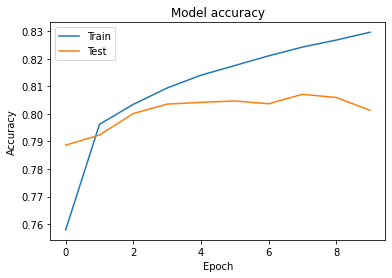

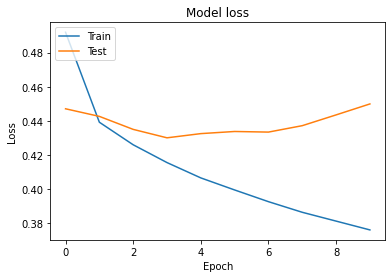

In [0]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show() 


## Actual predictions




In [0]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))- set(['no', 'not', 'nor'])
stemmer =  SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
def advanced_cleaning(text):
  text = text.split()
  # Remove stopwords
  text = [word for word in text if not word in stop_words]
  # Stem
  text = [stemmer.stem(word) for word in text]
  return ' '.join(text)

In [0]:
test_1 = "my favorite service out there i am simply in love with this"
test_2 = "good service personel is friendly and good job"
test_3 = "better than a lot of its competitors but a little bit under my expectations satisfying altogether"
test_4 = "maybe I like this service I am still not sure"
test_5 = "not the kind of service I would pay for but definetly something to keep a close eye on"
test_6 = "i am a little disappointed by this service"
test_7 = "not a good service very bad team abysmal experience what do u have exactly"
test_8 = "so bad absolutely one of the worst"
test_9 = "why all these bad predictions i can't understand"
test_10 = "i'm so sad from this confinment, god i hope it ends soon"

test_samples = [test_1,test_2,test_3,test_4,test_5,test_6,test_7,test_8,test_9, test_10]
test_samples = [advanced_cleaning(text) for text in test_samples]
test_samples_tokens = tokenizer.texts_to_sequences(test_samples)

predicted_tokenized = pad_sequences(test_samples_tokens, maxlen=MAX_WORDS, padding='post')
print(model.predict(predicted_tokenized))

print(model.predict_classes(predicted_tokenized))

[[0.98846805]
 [0.9780017 ]
 [0.9970459 ]
 [0.30772364]
 [0.2822285 ]
 [0.04498011]
 [0.01482147]
 [0.02558836]
 [0.04737676]
 [0.0294668 ]]
[[1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
